In [17]:
import localgraphclustering
import numpy as np
import pandas as pd
import time
from collections import namedtuple
import threading
import warnings
import math

import matplotlib.pyplot as plt

def graph_set_scores(graph, R):
    voltrue = sum(graph.d[R])     
    v_ones_R = np.zeros(graph._num_vertices)
    v_ones_R[R] = 1
    cut = voltrue - np.dot(v_ones_R,graph.adjacency_matrix.dot(v_ones_R.T))

    voleff = min(voltrue,graph.vol_G - voltrue)
    
    sizetrue = len(R)
    sizeeff = sizetrue
    if voleff < voltrue:
        sizeeff = graph._num_vertices - sizetrue
        
    # remove the stuff we don't want returned...
    del R
    del graph
    del v_ones_R

    edgestrue = voltrue - cut
    edgeseff = voleff - cut
    
    cond = cut / voleff
    isop = cut / sizeeff
    
    # make a dictionary out of local variables
    return locals()

def crd_wrapper(G,R,U=3,h=10,w=2,iterations=20):
    crd_fast = localgraphclustering.capacity_releasing_diffusion_fast.Capacity_Releasing_Diffusion_fast()
    #crd = localgraphclustering.capacity_releasing_diffusion_fast()
    return list(crd_fast.produce([G],R,U,h,w,iterations)[0])

def mqi_wrapper(G,R):
    MQI_fast_obj = localgraphclustering.MQI_fast.MQI_fast()
    output_MQI_fast = MQI_fast_obj.produce([G],[R])
    #print(output_MQI_fast)
    return output_MQI_fast[0][0].tolist()

"""
def acl_wrapper(G,R,eps):
    acl_fast = localclutering.approximate_PageRank_fast.Approximate_PageRank_fast()
    return list(acl_fast([G],[R],alpha=0.01,rho=eps,))
"""    

def ncp_experiment(ncpdata,R,func,method_stats):
    if ncpdata.input_stats:
        input_stats = graph_set_scores(ncpdata.graph, R)
        for F in ncpdata.set_funcs: # build the list of keys for set_funcs
            input_stats.update(F(ncpdata.graph, R))
        input_stats = {"input_" + str(key):value for key,value in input_stats.items() } # add input prefix
    else:
        input_stats = {}
        
    start = time.time()
    S = func(ncpdata.graph, R)
    dt = time.time() - start

    output_stats = graph_set_scores(ncpdata.graph, S)
    for F in ncpdata.set_funcs: # build the list of keys for set_funcs
        output_stats.update(F(ncpdata.graph, S))
    output_stats = {"output_" + str(key):value for key,value in output_stats.items() } # add output prefix

    method_stats['methodfunc']  = func
    method_stats['time'] = dt
    return ncpdata.record(**input_stats, **output_stats, **method_stats)

def ncp_node_worker(ncpdata,sets,func,timeout_ncp):
    start = time.time()
    setno = 0
    for R in sets:
        #print("setno = %i"%(setno))
        setno += 1
        
        method_stats = {'input_set_type': 'node', 'input_set_params':R[0]}
        ncpdata.results.append(ncp_experiment(ncpdata, R, func, method_stats))
        
        end = time.time()
        if end - start > timeout_ncp:
            break

# todo avoid code duplication 
def ncp_neighborhood_worker(ncpdata,sets,func,timeout_ncp):
    start = time.time()
    setno = 0
    for R in sets:
        #print("setno = %i"%(setno))
        setno += 1
        
        R = R.copy() # duplicate so we don't keep extra weird data around
        node = R[0]
        R.extend(ncpdata.graph.neighbors(R[0]))
        method_stats = {'input_set_type': 'neighborhood', 'input_set_params':node}
        
        ncpdata.results.append(ncp_experiment(ncpdata, R, func, method_stats))
        
        end = time.time()
        if end - start > timeout_ncp:
            break          
            
# todo avoid code duplication 
def ncp_set_worker(ncpdata,setnos,func,timeout_ncp):
    start = time.time()
    setno = 0
    for id in setnos:
        #print("setno = %i"%(setno))
        setno += 1
        R = ncpdata.sets[id]
        R = R.copy() # duplicate so we don't keep extra weird data around
        R.extend(ncpdata.graph.neighbors(R[0]))
        method_stats = {'input_set_type': 'set', 'input_set_params':id}
        
        ncpdata.results.append(ncp_experiment(ncpdata, R, func, method_stats))
        
        end = time.time()
        if end - start > timeout_ncp:
            break                   

class NCPData:
    ## This should go into the graph class, so we can call graph.largest_component() to get back this info! 
    def largest_component(graph):
        graph.connected_components()
        if graph.number_of_components == 1:
            graph.compute_statistics()
            return graph
        else:
            # biggest component by len of it's list of nodes
            maxccnodes = max(graph.components, key=len)            
            warnings.warn("The graph has multiple (%i) components, using the largest with %i / %i nodes"%(
                     graph.number_of_components, len(maxccnodes), graph._num_vertices))
            maxccnodes = list(maxccnodes)
            g_copy = localgraphclustering.graph_class_local.GraphLocal()
            g_copy.adjacency_matrix = graph.adjacency_matrix[maxccnodes,:].tocsc()[:,maxccnodes].tocsr()
            g_copy.compute_statistics()   
            g_copy._num_vertices = len(maxccnodes) # AHH!
            return g_copy
    
    def __init__(self, graph, setfuncs=[],input_stats=True):
        self.graph = NCPData.largest_component(graph)
        # Todo - have "largest_component" return a graph for the largest component
        self.input_stats = input_stats
        self.set_funcs = setfuncs        
        self.results = []

        standard_fields = graph_set_scores(self.graph, [0])
        for F in self.set_funcs: # build the list of keys for set_funcs
            standard_fields.update(F(self.graph, [0]))
        if self.input_stats:
            result_fields = ["input_" + field for field in standard_fields.keys()]
        result_fields.extend(["output_" + str(field) for field in standard_fields.keys()])
        result_fields.extend(["methodfunc", "input_set_type", "input_set_params", "time"])
        self.record = namedtuple("NCPDataRecord", field_names=result_fields)
        self.default_method = None
        self.sets = []
        
    def random_nodes(self, ratio):
        n = self.graph._num_vertices
        if 0 < ratio <= 1: 
            n_nodes = min(np.ceil(ratio*n),n)
            n_nodes = int(n_nodes)
        elif ratio > 1.0: # this is a number of nodes
            n_nodes = int(ratio) 
        else:
            raise(ValueError("the ratio parameter must be positive"))
            
        return np.random.choice(np.arange(0,n), size=n_nodes, replace=False)
        
    """ Decode and return the input set to a particular experiment. """
    def input_set(self, j): 
        result = self.results[j] # todo check for validity
        if result.input_set_type=="node":
            return [result.input_set_params]
        elif result.input_set_type=="neighborhood":
            R = self.graph.neighbors(result.input_set_params)
            R.append(result.input_set_params)
            return R
        elif result.input_set_type=="set":
            return self.sets[result.input_set_params].copy()
        else: 
            raise(ValueError("the input_set_type is unrecognized"))
        
    def output_set(self, j):
        result = self.results[j] # todo check for validity
        func = result.methodfunc
        R = self.input_set(j)
        return func(self.graph, R)
    
    def _check_method(self, method):
        if method == None:
            method = self.default_method
            if method == None:
                raise(ValueError("NCP call with method=None, but no default method specified"))
        return method
        
    def add_random_node_samples(self, ratio=0.3, timeout=1000, nthreads=4, method=None):
        method = self._check_method(method)
        nodes = self.random_nodes(ratio)
        
        threads = []
        threadnodes = np.array_split(nodes, nthreads)
        
        for i in range(nthreads):
            sets = [ [j] for j in threadnodes[i] ] # make a set of sets
            t = threading.Thread(target=ncp_node_worker,args=(self, sets, method, timeout))
            threads.append(t)
            t.start()
        for t in threads:
            t.join()
            
    def add_random_neighborhood_samples(self, ratio=0.3, timeout=1000, nthreads=4, method=None):
        method = self._check_method(method)
        nodes = self.random_nodes(ratio)
        
        threads = []
        threadnodes = np.array_split(nodes, nthreads)
        
        for i in range(nthreads):
            sets = [ [j] for j in threadnodes[i] ] # make a set of sets
            t = threading.Thread(target=ncp_neighborhood_worker,args=(self, sets, method, timeout))
            threads.append(t)
            t.start()
        for t in threads:
            t.join()
            
    def add_set_samples(self, sets, nthreads=4, method=None):
        method = self._check_method(method)
        threads = []
        startset = len(ncp.sets)
        self.sets.extend(sets)
        endset = len(ncp.sets)
        
        setnos = np.array_split(range(startset,endset)) # set numbers
        
        for i in range(nthreads):
            t = threading.Thread(target=ncp_set_worker,args=(self, setnos[i], method, timeout))
            threads.append(t)
            t.start()
        for t in threads:
            t.join()
        
    def as_data_frame(self):
        return pd.DataFrame.from_records(self.results, columns=self.record._fields)

    
def ncp_min_cond_func(grp):
    minj = grp["output_cond"].idxmin()
    #print(grp["output_cond"])
    result = grp.loc[minj]
    result["best"] = minj
    return result
    #return grp
    
def ncp_min(grp, feature):
    minj = grp[feature].idxmin()
    result = grp.loc[minj]
    result["best"] = minj
    return result

def ncp_min_feature_by_group(df, feature, group):
    return df.groupby(group).apply(lambda x: ncp_min(x, feature))

class NCPPlots:
    def __init__(self, df):
        self.df = df
        
    def feature_by_group(self, feature, group):
        ax = df.plot.scatter(x=group, y=feature)
        ncp_min_feature_by_group(df, feature, group).plot.line(
                x=group, y=feature, ax=ax)
        plt.show()
        return ax
        
    def cond_by_size(self):
        return self.feature_by_group("output_cond", "output_sizeeff")

    def cond_by_vol(self):
        ax = df.plot.scatter(x="output_voleff", y="output_cond")
        ncp_min_feature_by_group(df, "output_cond", "output_voleff").plot.line(
                x="output_voleff", y="output_cond", ax=ax)
        plt.show()        
        
    def isop_by_size(self):
        ax = df.plot.scatter(x="output_sizeeff", y="output_isop")
        ncp_min_feature_by_group(df, "output_isop", "output_sizeeff").plot.line(
                x="output_sizeeff", y="output_isop", ax=ax)

There are  14  connected components in the graph


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: UserWarning: The graph has multiple (14) components, using the largest with 5725 / 5752 nodes


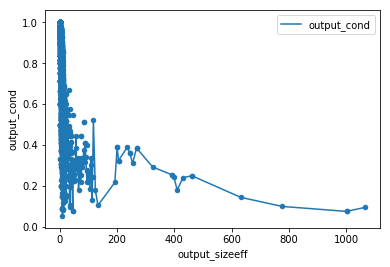

In [9]:
"""
Run a CRD NCP
"""
G = localgraphclustering.graph_class_local.GraphLocal()
G.read_graph("../../data/neuro-fmri-01.edges","edgelist", " ")
G.compute_statistics()
ncp = NCPData(G)    
ncp.default_method = lambda G,R: crd_wrapper(G,R,w=10, U=10, h=1000)
ncp.add_random_neighborhood_samples(ratio=0.3,nthreads=4)
ncp.add_random_node_samples(ratio=0.3,nthreads=4)
df = ncp.as_data_frame()


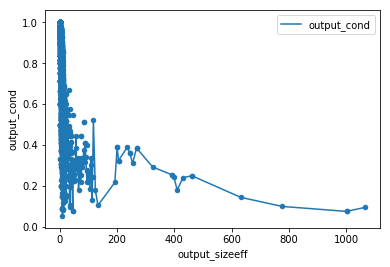

AttributeError: 'AxesSubplot' object has no attribute 'show'

In [22]:
ax = NCPPlots(df).cond_by_size()
ax.set_xscale("log")
ax.set_yscale("log")


There are  14  connected components in the graph


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: The graph has multiple (14) components, using the largest with 5725 / 5752 nodes


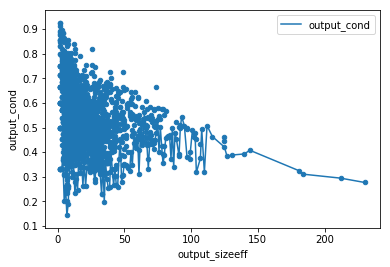

In [8]:
"""
Run an MQI NCP
"""
G = localgraphclustering.graph_class_local.GraphLocal()
G.read_graph("../../data/neuro-fmri-01.edges","edgelist", " ")
G.compute_statistics()
ncp = NCPData(G)    
#ncp.default_method = lambda G,R: crd_wrapper(G,R,w=10, U=10, h=1000)
ncp.default_method = lambda G,R: mqi_wrapper(G,R)
ncp.add_random_neighborhood_samples(ratio=0.3,nthreads=4)
#ncp.add_random_neighborhood_samples(ratio=0.3,nthreads=4,method=lambda G,R: crd_wrapper(G,R,w=10,U=10,h=1000,iterations=200))
df = ncp.as_data_frame()
NCPPlots(df).cond_by_size()

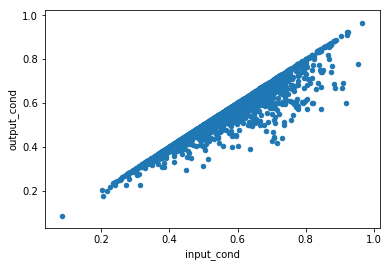

In [3]:
df.plot.scatter(x="input_cond", y="output_cond")
plt.show()

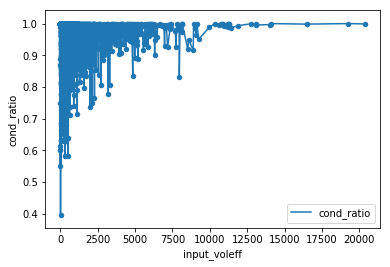

In [11]:
df["cond_ratio"] = df["output_cond"]/df["input_cond"]
NCPPlots(df).feature_by_group("cond_ratio", "input_voleff")

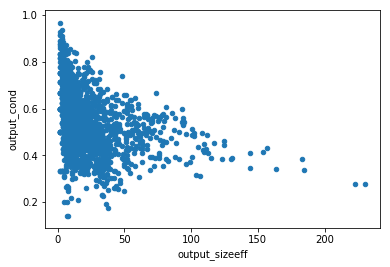

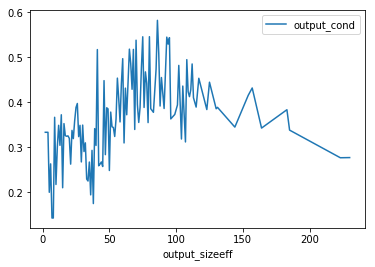

In [4]:
df.plot.scatter(x="output_sizeeff", y="output_cond")
ncp_min_cond_by_feature(df, "output_sizeeff").plot.line(x="output_sizeeff", y="output_cond")
plt.show()


In [17]:
G = localgraphclustering.graph_class_local.GraphLocal()
G.read_graph("../../data/neurosynth-meta.edges","edgelist", " ")
G.compute_statistics()
ncp = NCPData(G)    
#ncp.default_method = lambda G,R: crd_wrapper(G,R,w=10, U=10, h=1000)
ncp.default_method = lambda G,R: mqi_wrapper(G,R)
ncp.add_random_neighborhood_samples(ratio=0.3,nthreads=4)
df = ncp.as_data_frame()
df

FileNotFoundError: [Errno 2] No such file or directory: '../../data/neurosynth-meta.edges'

In [12]:
"""
Run an MQI NCP
"""
G = localgraphclustering.graph_class_local.GraphLocal()
G.read_graph("../../data/ppi-homo.edges","edgelist", " ")
G.compute_statistics()
ncp = NCPData(G)    
#ncp.default_method = lambda G,R: crd_wrapper(G,R,w=10, U=10, h=1000)
ncp.default_method = lambda G,R: mqi_wrapper(G,R)
ncp.add_random_neighborhood_samples(ratio=0.3,nthreads=4)
df = ncp.as_data_frame()
df

There are  1  connected components in the graph


,input_isop,input_cond,input_edgeseff,input_edgestrue,input_sizeeff,input_sizetrue,input_voleff,input_cut,input_voltrue,output_isop,...,output_edgestrue,output_sizeeff,output_sizetrue,output_voleff,output_cut,output_voltrue,methodfunc,input_set_type,input_set_params,time
0,2.000000,0.500000,4.0,4.0,2,2,8.0,4.0,8.0,2.000000,...,4.0,2,2,8.0,4.0,8.0,<function <lambda> at 0x10dea9400>,neighborhood,2742,0.001314
1,39.000000,0.921260,20.0,20.0,6,6,254.0,234.0,254.0,14.000000,...,8.0,3,3,50.0,42.0,50.0,<function <lambda> at 0x10dea9400>,neighborhood,3165,0.003463
2,129.000000,0.984733,4.0,4.0,2,2,262.0,258.0,262.0,129.000000,...,4.0,2,2,262.0,258.0,262.0,<function <lambda> at 0x10dea9400>,neighborhood,2653,0.001967
3,97.571429,0.929252,104.0,104.0,14,14,1470.0,1366.0,1470.0,17.200000,...,20.0,5,5,106.0,86.0,106.0,<function <lambda> at 0x10dea9400>,neighborhood,6895,0.002297
4,24.166667,0.857988,48.0,48.0,12,12,338.0,290.0,338.0,6.666667,...,20.0,6,6,60.0,40.0,60.0,<function <lambda> at 0x10dea9400>,neighborhood,2393,0.001344
5,93.000000,0.978947,4.0,4.0,2,2,190.0,186.0,190.0,93.000000,...,4.0,2,2,190.0,186.0,190.0,<function <lambda> at 0x10dea9400>,neighborhood,8669,0.002063
6,117.000000,0.961644,28.0,28.0,6,6,730.0,702.0,730.0,5.000000,...,4.0,2,2,14.0,10.0,14.0,<function <lambda> at 0x10dea9400>,neighborhood,4299,0.001410
7,7.000000,0.538462,24.0,24.0,4,4,52.0,28.0,52.0,3.333333,...,12.0,3,3,22.0,10.0,22.0,<function <lambda> at 0x10dea9400>,neighborhood,4142,0.001626
8,162.250000,0.925820,104.0,104.0,8,8,1402.0,1298.0,1402.0,14.000000,...,84.0,7,7,182.0,98.0,182.0,<function <lambda> at 0x10dea9400>,neighborhood,3835,0.001277
9,18.666667,0.875000,8.0,8.0,3,3,64.0,56.0,64.0,7.000000,...,4.0,2,2,18.0,14.0,18.0,<function <lambda> at 0x10dea9400>,neighborhood,5231,0.002074


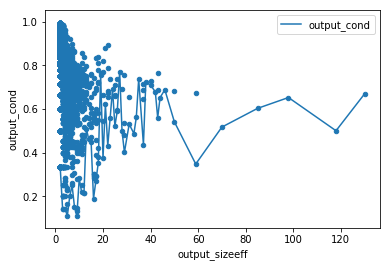

In [13]:
df = ncp.as_data_frame()
NCPPlots(df).cond_by_size()

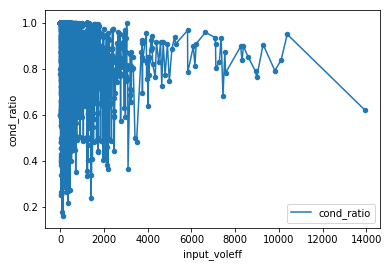

In [14]:
df["cond_ratio"] = df["output_cond"]/df["input_cond"]
NCPPlots(df).feature_by_group("cond_ratio", "input_voleff")

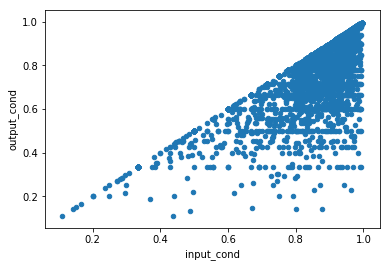

In [16]:
df.plot.scatter(x="input_cond", y="output_cond")
plt.show()


There are  1  connected components in the graph


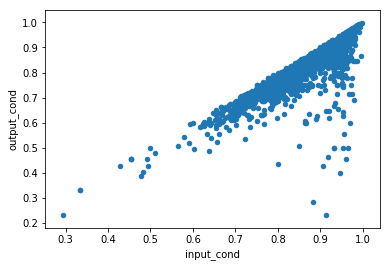

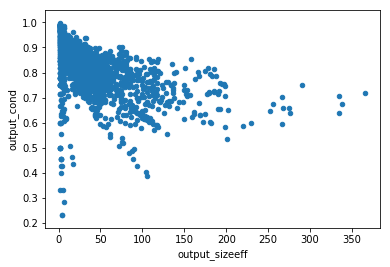

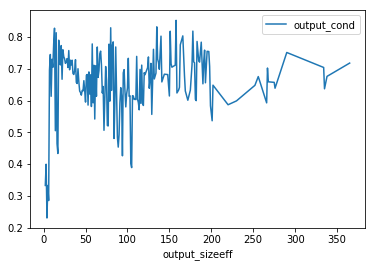

In [10]:
"""
Run an MQI NCP
"""
G = localgraphclustering.graph_class_local.GraphLocal()
G.read_graph("JohnsHopkins.edgelist","edgelist", "\t")
G.compute_statistics()
ncp = NCPData(G)    
#ncp.default_method = lambda G,R: crd_wrapper(G,R,w=10, U=10, h=1000)
ncp.default_method = lambda G,R: mqi_wrapper(G,R)
ncp.add_random_neighborhood_samples(ratio=0.3,nthreads=4)
df = ncp.as_data_frame()
df.plot.scatter(x="input_cond", y="output_cond")
plt.show()
df.plot.scatter(x="output_sizeeff", y="output_cond")
ncp_min_cond_by_feature(df, "output_sizeeff").plot.line(x="output_sizeeff", y="output_cond")
plt.show()

In [2]:
"""
Run an MQI NCP
"""
G = localgraphclustering.graph_class_local.GraphLocal()
G.read_graph("../../data/wiki-cats.edges","edgelist", " ")
G.compute_statistics()
ncp = NCPData(G)    
#ncp.default_method = lambda G,R: crd_wrapper(G,R,w=10, U=10, h=1000)
#ncp.default_method = lambda G,R: mqi_wrapper(G,R)
##ncp.add_random_neighborhood_samples(ratio=0.3,nthreads=4)
#df = ncp.as_data_frame()
#df

There are  513  connected components in the graph


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: The graph has multiple (513) components, using the largest with 159103 / 160277 nodes


In [4]:
mqi_wrapper(ncp.graph,  [0,1,2,3,4,5])

[4, 2]